In [1]:
from __future__ import division, print_function

# Standard lib
import os

# Third-party
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Custom
import astropy.coordinates as coord
import gary.coordinates as gc
import gary.dynamics as gd
import gary.integrate as gi
import gary.io as io
import gary.potential as gp
from gary.units import galactic

# project
from streammorphology.freqmap import read_allfreqs

In [13]:
path = "/Users/adrian/projects/morphology/output/freqmap/triaxial-NFW/paper1_zoom/"

In [14]:
d = read_allfreqs(os.path.join(path, "allfreqs.dat"))
w0 = np.load(os.path.join(path,"w0.npy"))
potential = gp.load(os.path.join(path,"potential.yml"))

In [15]:
print(d.dtype.names)

('freqs', 'dE_max', 'success', 'is_tube', 'dt', 'nsteps', 'max_amp_freq_ix', 'error_code')


In [16]:
# take mean of determined periods
periods = np.mean(np.abs(2*np.pi / d['freqs']), axis=1)
nperiods = (d['dt']*d['nsteps'])[:,None] / periods / 2.

# compute the frequency diffusion per orbit in each component
freq_diff_per_orbit = np.abs((np.abs(d['freqs'][:,1]) - np.abs(d['freqs'][:,0])) / d['freqs'][:,0] / nperiods)

# now only take the strongest component
ix = d['max_amp_freq_ix']
max_freq_diff_per_orbit = np.array([freq_diff_per_orbit[j,i] for j,i in enumerate(ix)])

goody_ix = np.isfinite(max_freq_diff_per_orbit)
fdiff = np.log10(max_freq_diff_per_orbit)

(22, 27)

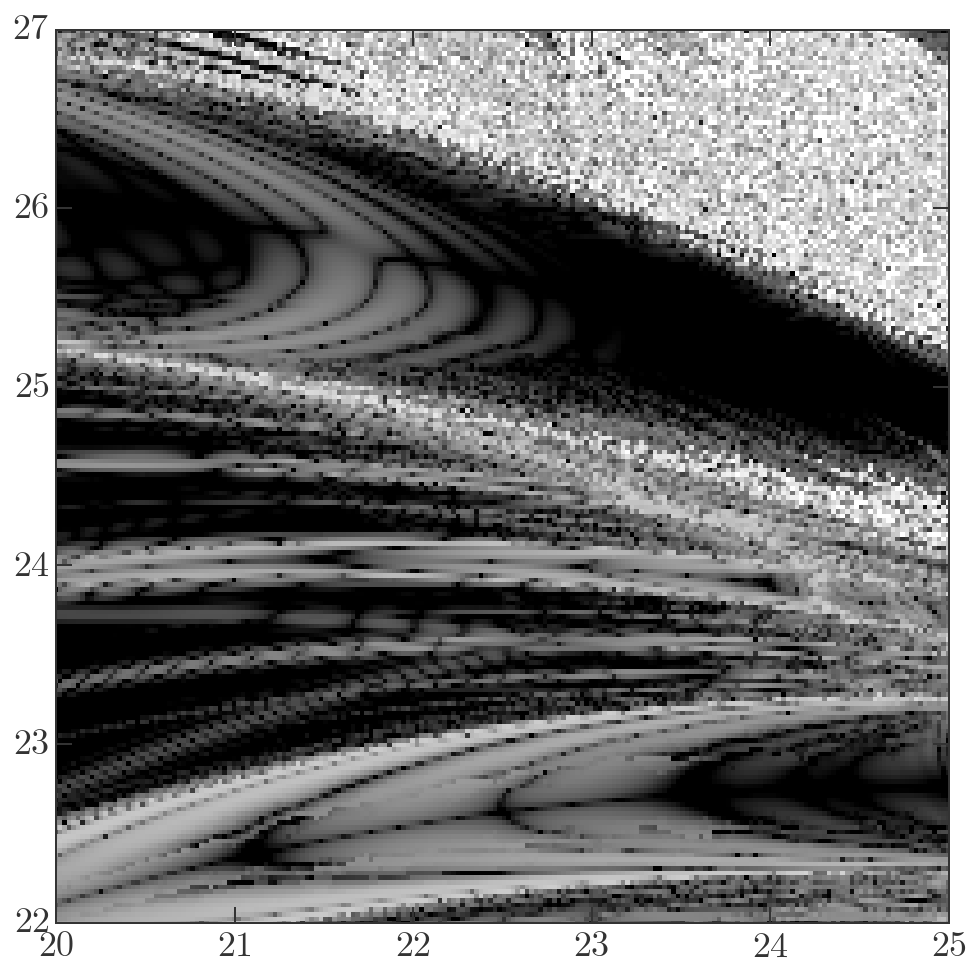

In [20]:
plt.figure(figsize=(8,8))
plt.scatter(w0[goody_ix,0], w0[goody_ix,2], c=fdiff[goody_ix], 
            s=10., marker='s', cmap='Greys_r', vmin=-8, vmax=-3)
plt.xlim(20,25)
plt.ylim(22,27)

Pick out a single column

In [116]:
col,rows = 24,(25.1,26.)

col_ix = w0[goody_ix,0] == w0[((w0[goody_ix,0] - col)**2).argmin(), 0]
row_ix = (w0[goody_ix,2][col_ix] > rows[0]) & (w0[goody_ix,2][col_ix] < rows[1])

print(fdiff[goody_ix][col_ix][row_ix].max(), fdiff[goody_ix][col_ix][row_ix].min())
fast_w0 = w0[goody_ix][col_ix][row_ix][fdiff[goody_ix][col_ix][row_ix].argmax()]
slow_w0 = w0[goody_ix][col_ix][row_ix][fdiff[goody_ix][col_ix][row_ix].argmin()]

-2.87242866935 -13.2668920633


In [117]:
print(fast_w0[:3])
print((fast_w0[4]*u.kpc/u.Myr).to(u.km/u.s).value)
print()
print(slow_w0[:3])
print((slow_w0[4]*u.kpc/u.Myr).to(u.km/u.s).value)

[ 23.97435897   0.          25.69230769]
101.130215112

[ 23.97435897   0.          25.23076923]
104.745954922


In [118]:
print(slow_w0.tolist())
print(fast_w0.tolist())

[23.974358974358974, 0.0, 25.23076923076923, 0.0, 0.10712496233879222, 0.0]
[23.974358974358974, 0.0, 25.692307692307693, 0.0, 0.10342710124919148, 0.0]


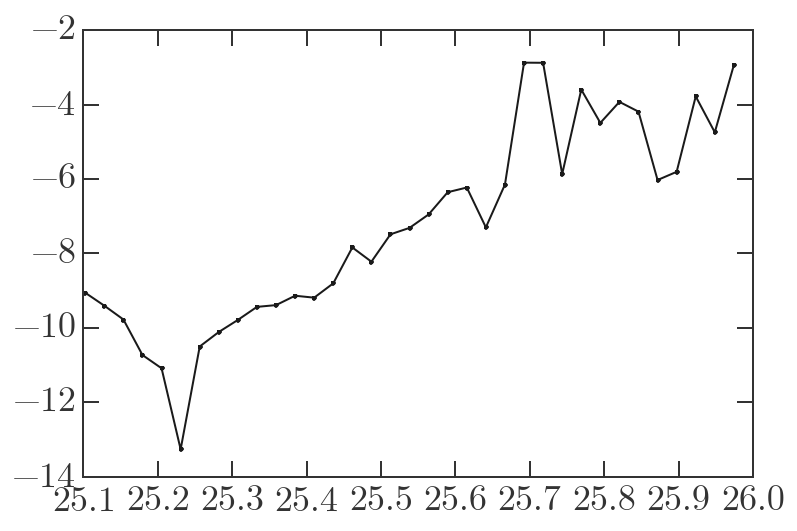

In [119]:
plt.plot(w0[goody_ix][col_ix][row_ix][:,2], fdiff[goody_ix][col_ix][row_ix])

In [120]:
slow_fast_w0 = np.vstack((slow_w0, fast_w0))
print(slow_fast_w0.tolist())

[[23.974358974358974, 0.0, 25.23076923076923, 0.0, 0.10712496233879222, 0.0], [23.974358974358974, 0.0, 25.692307692307693, 0.0, 0.10342710124919148, 0.0]]


## Check KLD

In [121]:
from streammorphology.ensemble import create_ball, nearest_pericenter
from streammorphology.ensemble.fast_ensemble import ensemble_integrate
from streammorphology.freqmap import estimate_dt_nsteps

from sklearn.neighbors import KernelDensity
from scipy.stats import kurtosis, skew

In [125]:
def do_the_kld(ball_w0, potential, dt, nsteps, nkld, kde_bandwidth, metrics=dict(mean=np.mean)):
    ww = np.ascontiguousarray(ball_w0.copy())
    nensemble = ww.shape[0]

#     kld_idx = np.append(np.linspace(0, nsteps//4, nkld//2+1),
#                         np.linspace(nsteps//4, nsteps, nkld//2+1)[1:]).astype(int)
    kld_idx = np.linspace(0, nsteps, nkld+1).astype(int)
    
    # sort so I preserve some order around here
    metric_names = sorted(metrics.keys())
    
    # container to store fraction of stars with density above each threshold
    dtype = []
    for name in metric_names:
        dtype.append((name,'f8'))
    metric_data = np.zeros(nkld, dtype=dtype)
    
    Es = np.empty((nkld+1,nensemble))
    Es[0] = potential.total_energy(ball_w0[:,:3], ball_w0[:,3:])
    
    # time container
    t = np.empty(nkld)
    for i in range(nkld):
        print("KLD step: {0}/{1}".format(i+1, nkld))

        # number of steps to advance the ensemble -- not necessarily constant
        dstep = kld_idx[i+1] - kld_idx[i]
        www = ensemble_integrate(potential.c_instance, ww, dt, dstep, 0.)

        Es[i+1] = potential.total_energy(www[:,:3], www[:,3:])
        
        # store the time
        if i == 0:
            t[i] = dt*dstep
        else:
            t[i] = t[i-1] + dt*dstep

        # build an estimate of the configuration space density of the ensemble
        kde = KernelDensity(kernel='epanechnikov', bandwidth=kde_bandwidth)
        kde.fit(www[:,:3])
        
        # evaluate density at the position of the particles
        ln_densy = kde.score_samples(www[:,:3])
        density = np.exp(ln_densy)

        # evaluate the metrics and save
        for name in metric_names:
            metric_data[name][i] = metrics[name](density)
        
        # reset initial conditions
        ww = www.copy()

    return t, metric_data, Es

In [127]:
kde_bandwidth = 5.
nball = 100
nkld = 256
m_scale = 1E1

all_ts = []
all_metrics = []
for this_w0 in slow_fast_w0:
    dt,nsteps = estimate_dt_nsteps(potential, this_w0, nperiods=50, nsteps_per_period=250)
    ball_w0 = create_ball(this_w0, potential, N=nball, m_scale=m_scale)
    
    kde = KernelDensity(kernel='epanechnikov', bandwidth=kde_bandwidth)
    kde.fit(ball_w0[:,:3])
    thresh = np.exp(kde.score_samples(ball_w0[:,:3])).mean() / 10.
    metrics = dict(mean=np.mean, 
                   median=np.median, 
                   skewness_log=lambda x: skew(np.log10(x)), 
                   kurtosis_log=lambda x: kurtosis(np.log10(x)),
                   mean_log=lambda x: np.mean(np.log10(x)), 
                   median_log=lambda x: np.median(np.log10(x)), 
                   nabove=lambda x: (x > thresh).sum())
    
    ttt,mmm,ballE = do_the_kld(ball_w0, potential, nkld=nkld, dt=dt, nsteps=nsteps, 
                           kde_bandwidth=kde_bandwidth, metrics=metrics)
    all_ts.append(ttt)
    all_metrics.append(mmm)
    
    break

KLD step: 1/256
KLD step: 2/256
KLD step: 3/256
KLD step: 4/256
KLD step: 5/256
KLD step: 6/256
KLD step: 7/256
KLD step: 8/256
KLD step: 9/256
KLD step: 10/256
KLD step: 11/256
KLD step: 12/256
KLD step: 13/256
KLD step: 14/256
KLD step: 15/256
KLD step: 16/256
KLD step: 17/256
KLD step: 18/256
KLD step: 19/256
KLD step: 20/256
KLD step: 21/256
KLD step: 22/256
KLD step: 23/256
KLD step: 24/256
KLD step: 25/256
KLD step: 26/256
KLD step: 27/256
KLD step: 28/256
KLD step: 29/256
KLD step: 30/256
KLD step: 31/256
KLD step: 32/256
KLD step: 33/256
KLD step: 34/256
KLD step: 35/256
KLD step: 36/256
KLD step: 37/256
KLD step: 38/256
KLD step: 39/256
KLD step: 40/256
KLD step: 41/256
KLD step: 42/256
KLD step: 43/256
KLD step: 44/256
KLD step: 45/256
KLD step: 46/256
KLD step: 47/256
KLD step: 48/256
KLD step: 49/256
KLD step: 50/256
KLD step: 51/256
KLD step: 52/256
KLD step: 53/256
KLD step: 54/256
KLD step: 55/256
KLD step: 56/256
KLD step: 57/256
KLD step: 58/256
KLD step: 59/256
KLD st

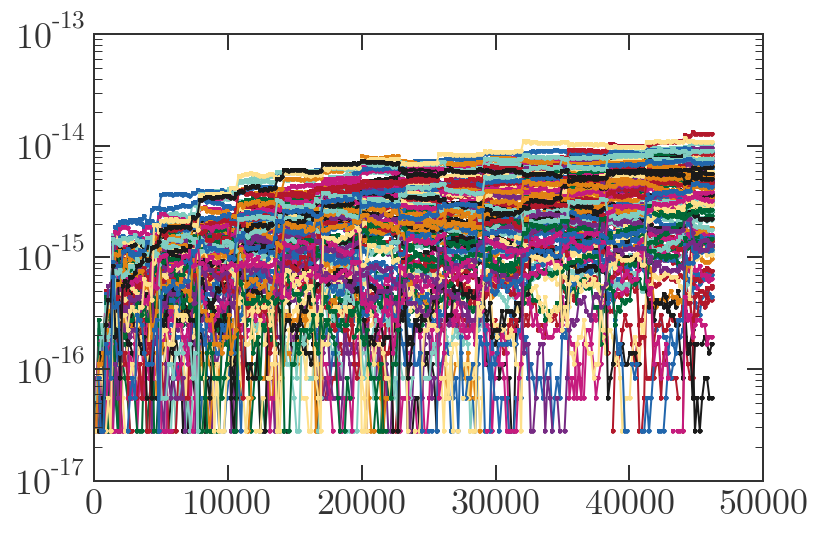

In [131]:
plt.semilogy(ttt, np.abs(ballE[1:] - ballE[0]));

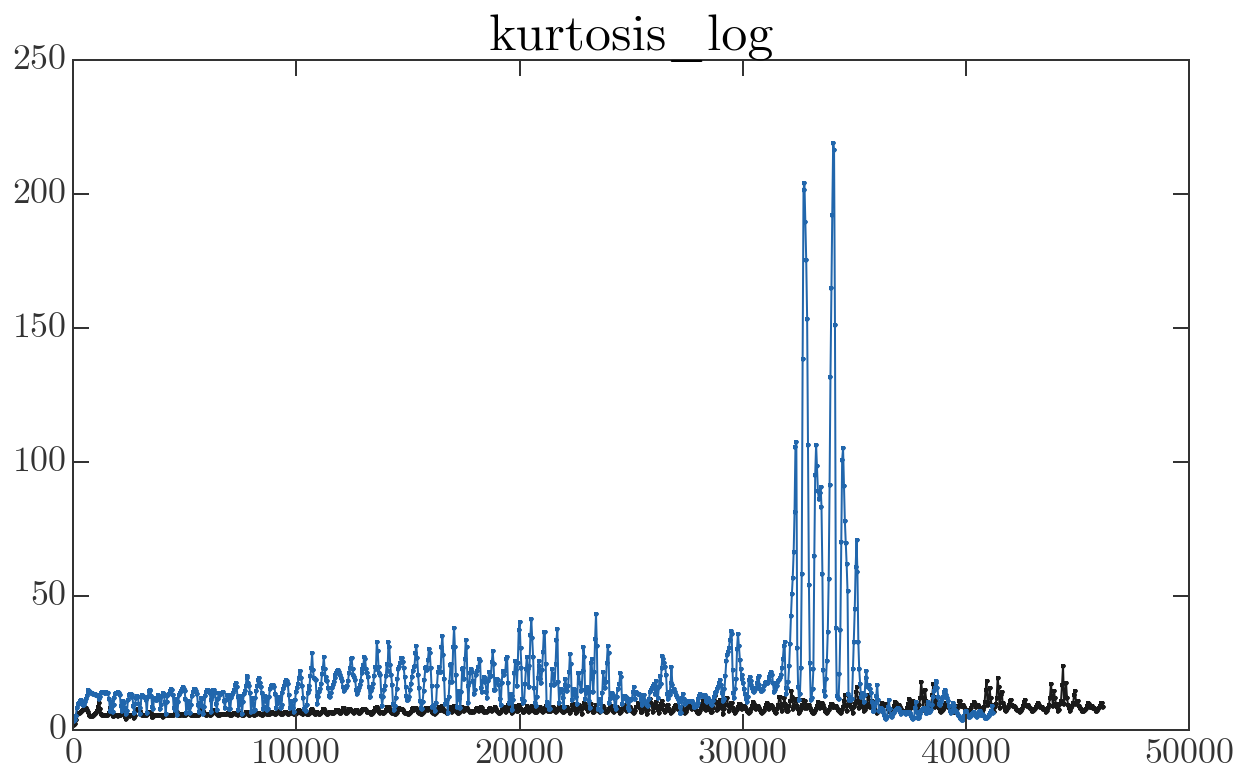

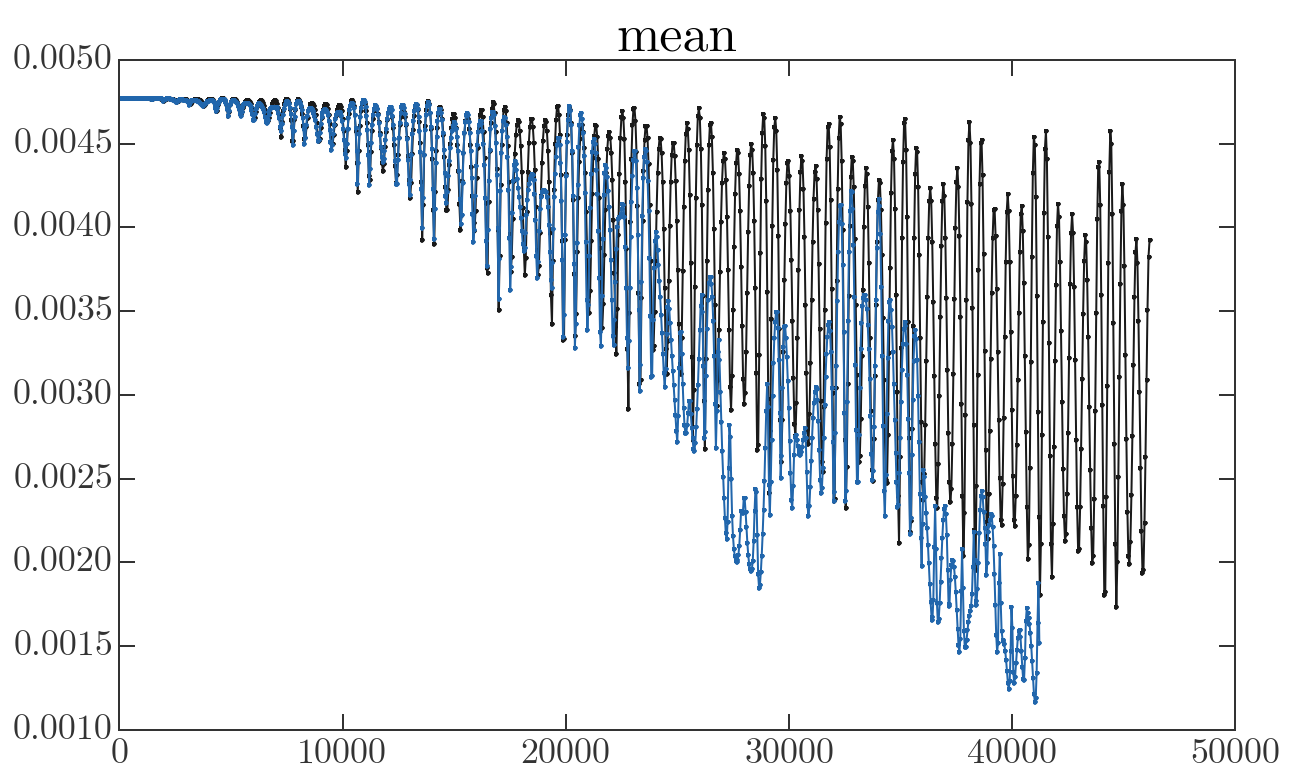

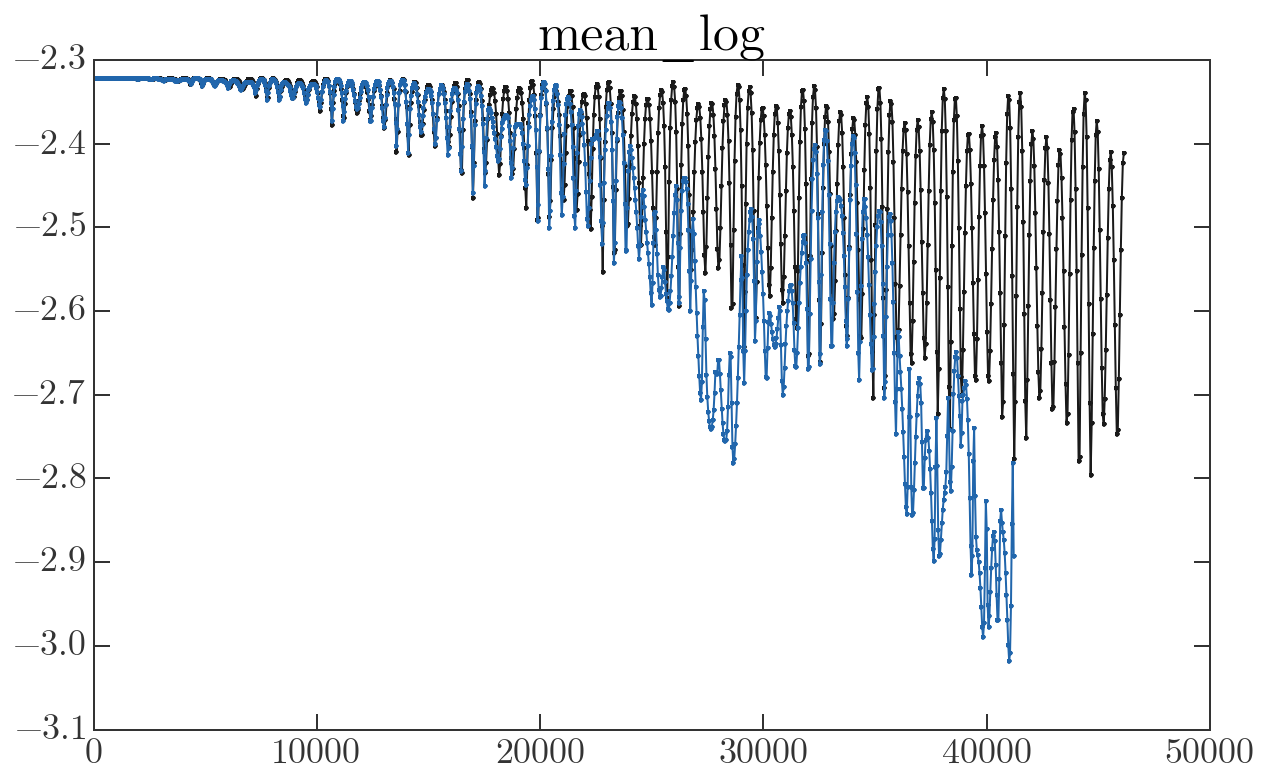

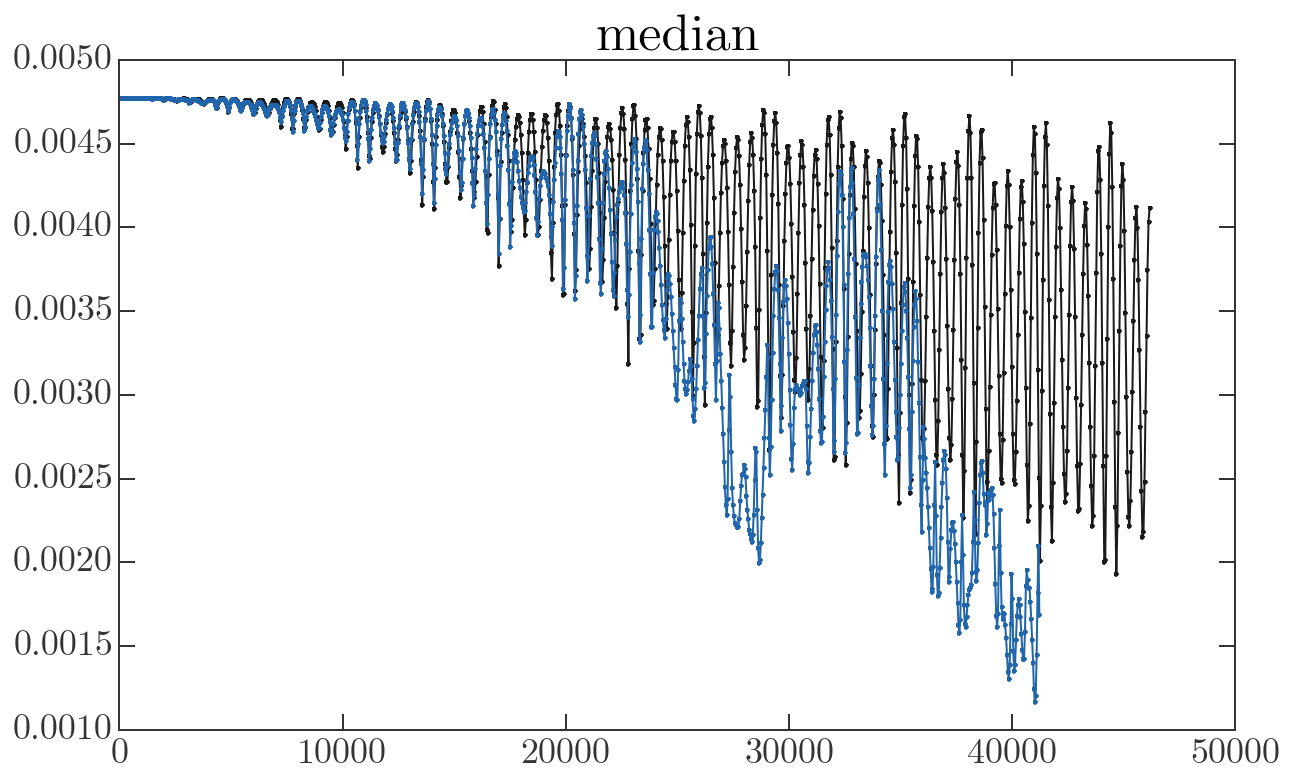

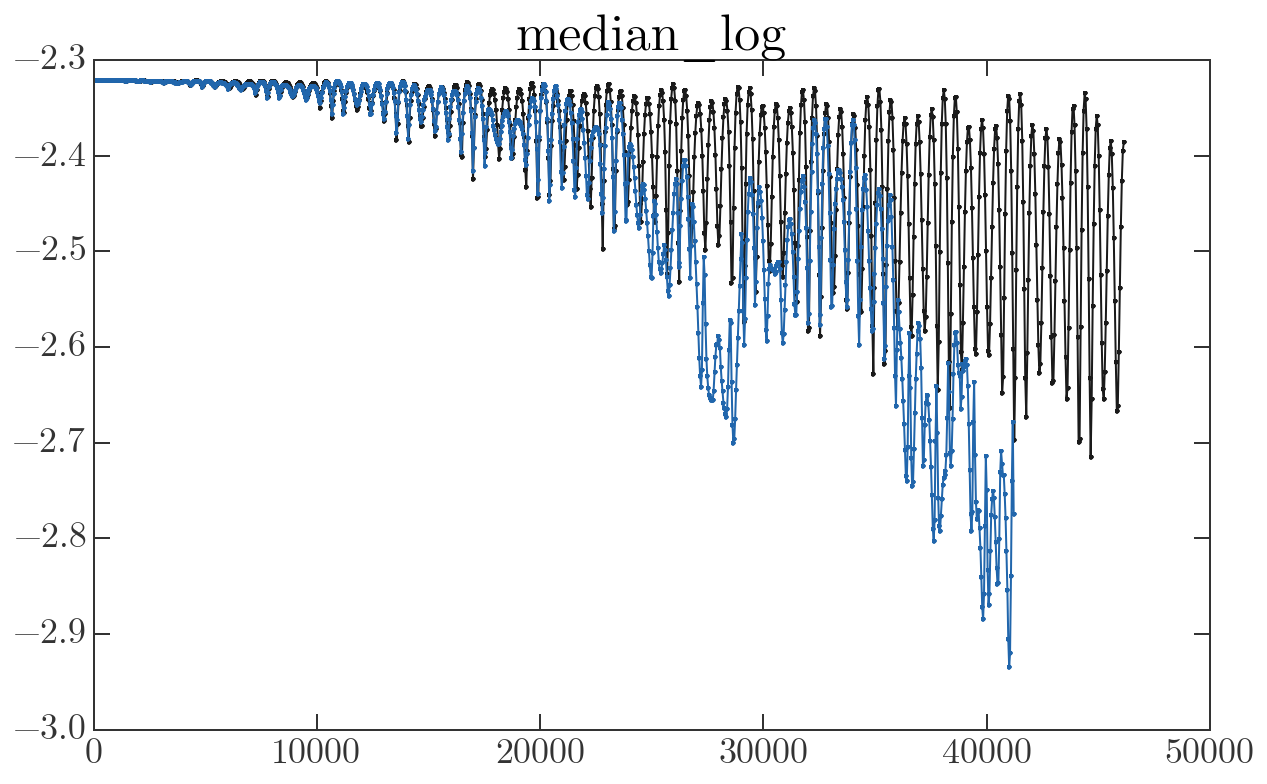

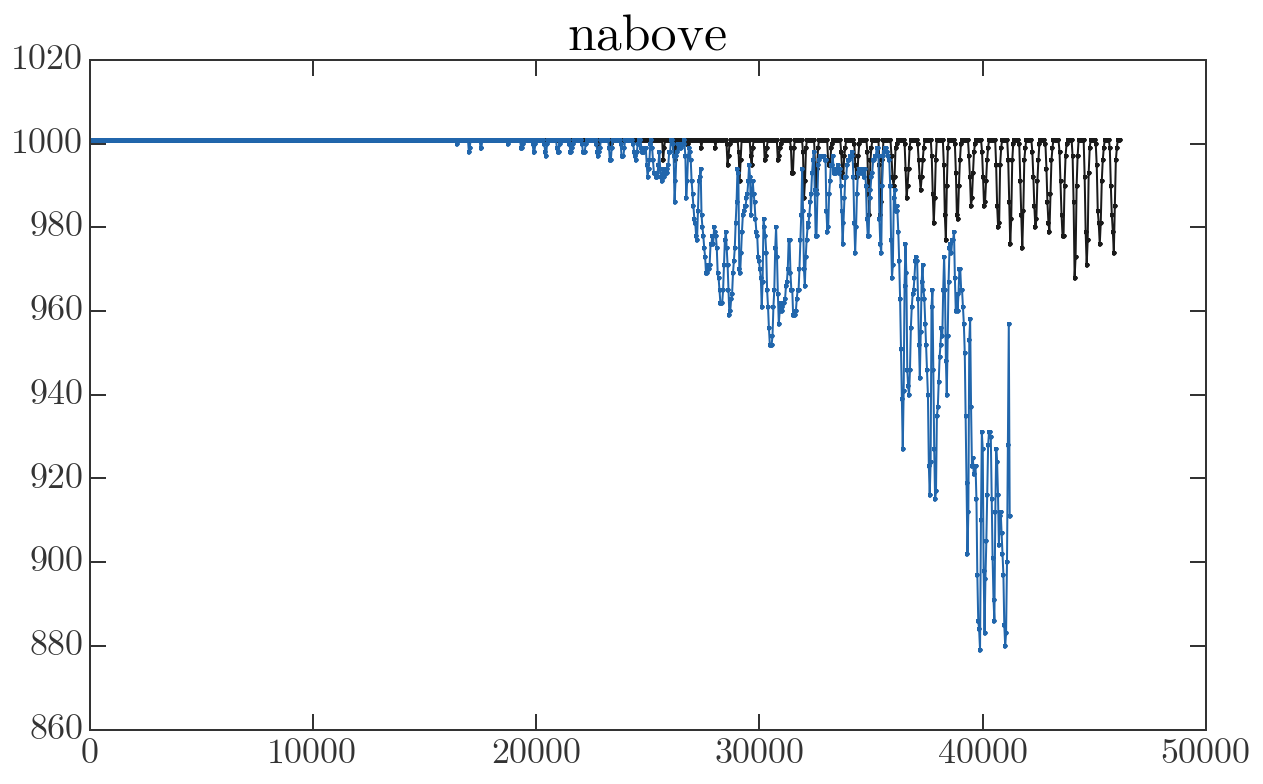

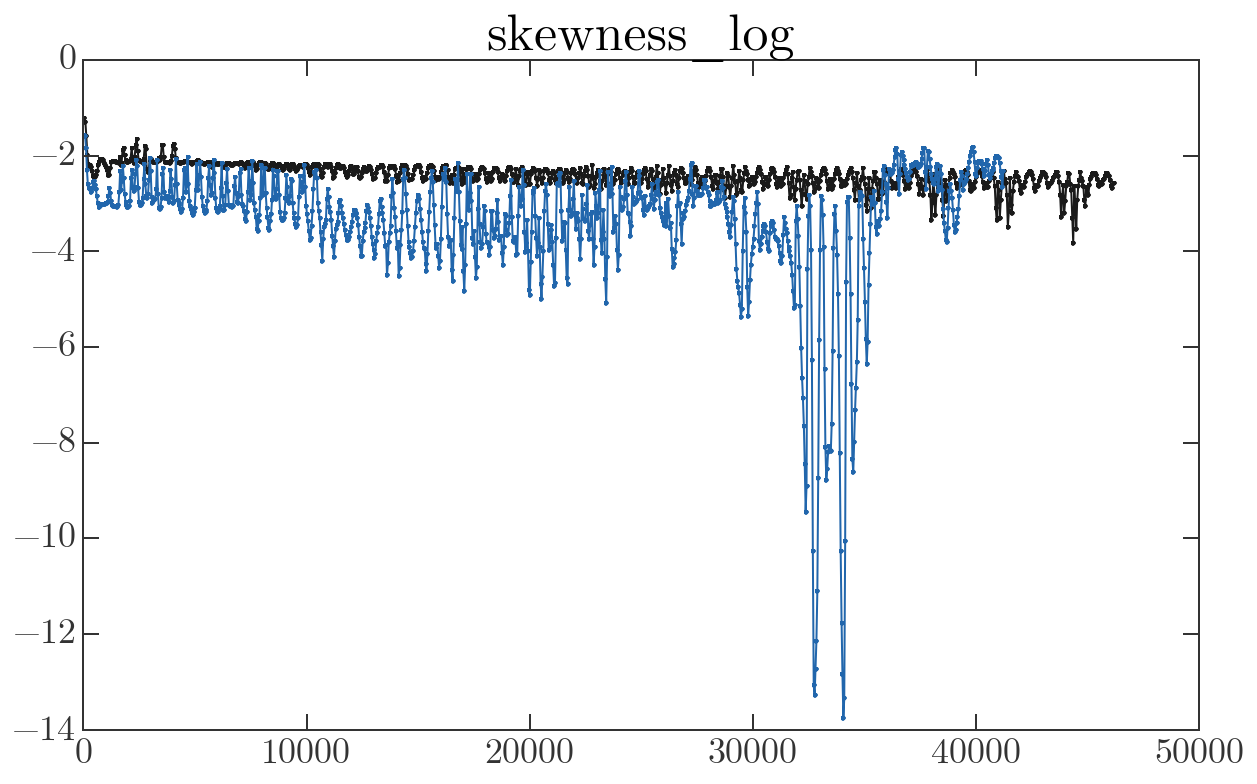

In [124]:
for name in sorted(metrics.keys()):
    plt.figure(figsize=(10,6))
    plt.plot(all_ts[0], all_metrics[0][name])
    plt.plot(all_ts[1], all_metrics[1][name])
    plt.title(name)

In [31]:
sf_t,sf_w = potential.integrate_orbit(slow_fast_w0, dt=1., nsteps=int(max(20000, evln_time)), 
                                      Integrator=gi.DOPRI853Integrator)

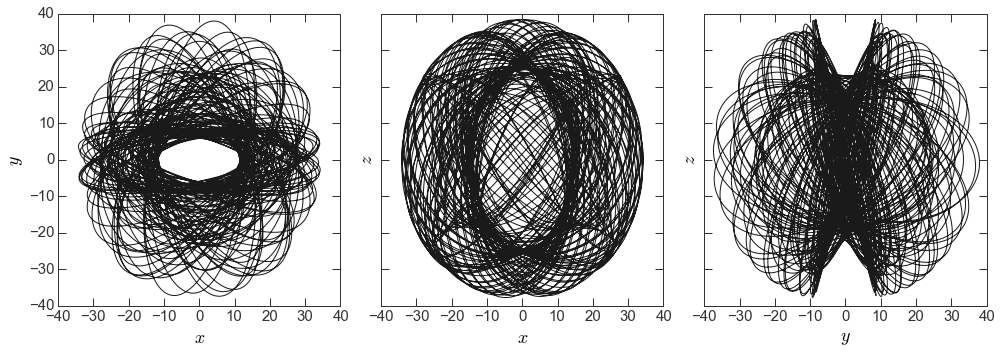

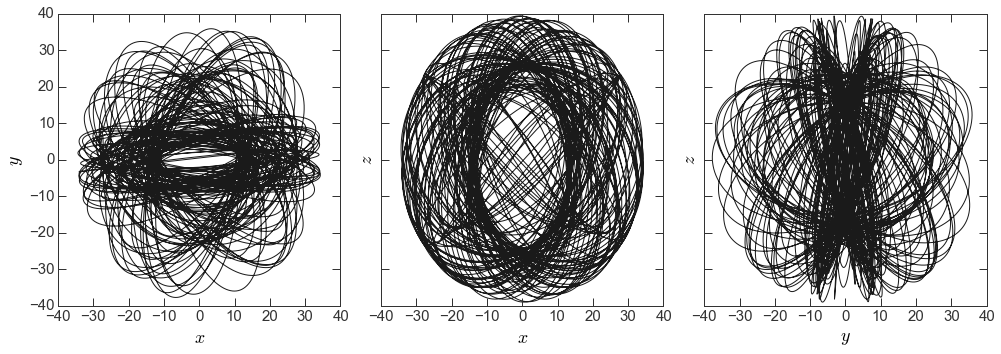

In [32]:
fig = gd.plot_orbits(sf_w, ix=0, marker=None, subplots_kwargs=dict(sharex=True, sharey=True))
fig = gd.plot_orbits(sf_w, ix=1, marker=None, subplots_kwargs=dict(sharex=True, sharey=True))

### Identify first pericenter, then find apocenter closest to 10 Gyr later

In [33]:
from scipy.signal import argrelmax, argrelmin

In [34]:
sph = coord.CartesianRepresentation(sf_w[:,:,:3].T*u.kpc).represent_as(coord.SphericalRepresentation)
Rs = sph.distance.value

In [35]:
slow_apos = argrelmax(Rs[0])[0]
slow_pers = argrelmin(Rs[0])[0]

fast_apos = argrelmax(Rs[1])[0]
fast_pers = argrelmin(Rs[1])[0]

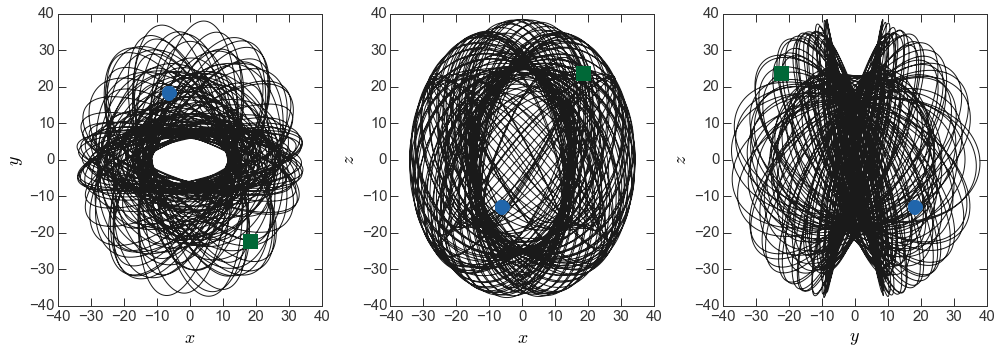

In [36]:
t1 = sf_t[slow_pers[0]]
t2 = sf_t[slow_apos]
t2 = sf_t[slow_apos[np.abs((t2-t1) - evln_time).argmin()]]

slow_dt = 1.
slow_nsteps = int((t2-t1) / slow_dt)
slow_w0 = sf_w[slow_pers[0], 0]

derp,herp = potential.integrate_orbit(slow_w0, dt=slow_dt, nsteps=slow_nsteps, 
                                      Integrator=gi.DOPRI853Integrator)

fig = gd.plot_orbits(herp, marker=None)
fig = gd.plot_orbits(herp[0], marker='o', axes=fig.axes, ms=15.)
fig = gd.plot_orbits(herp[-1], marker='s', axes=fig.axes, ms=15.)

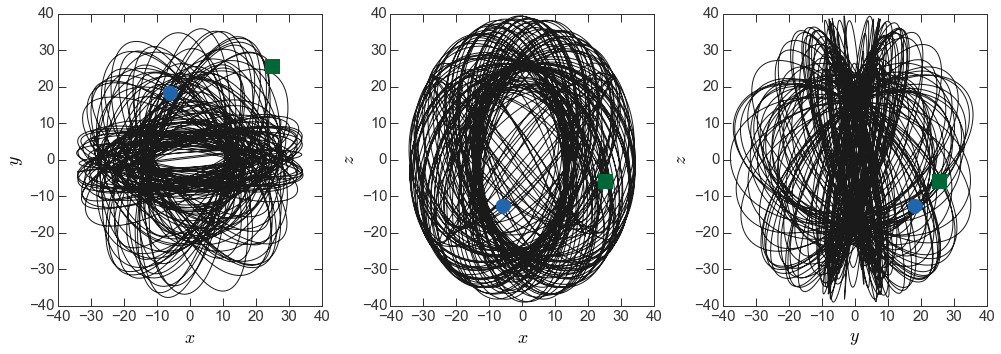

In [37]:
t1 = sf_t[fast_pers[0]]
t2 = sf_t[fast_apos]
t2 = sf_t[fast_apos[np.abs((t2-t1) - evln_time).argmin()]]

fast_dt = 1.
fast_nsteps = int((t2-t1) / slow_dt)
fast_w0 = sf_w[fast_pers[0], 1]

derp,herp = potential.integrate_orbit(fast_w0, dt=fast_dt, nsteps=fast_nsteps, 
                                      Integrator=gi.DOPRI853Integrator)

fig = gd.plot_orbits(herp, marker=None)
fig = gd.plot_orbits(herp[0], marker='o', axes=fig.axes, ms=15.)
fig = gd.plot_orbits(herp[-1], marker='s', axes=fig.axes, ms=15.)

In [163]:
def create_ball(w0, potential, N=100):
    menc = potential.mass_enclosed(w0)
    rscale = (2.5E4 / (3*menc))**(1/3.) * np.sqrt(np.sum(w0[:3]**2))
    vscale = (2.5E4 / (3*menc))**(1/3.) * np.sqrt(np.sum(w0[3:]**2))
    
    ball_w0 = np.zeros((N,6))
    
    # r = rscale * np.random.uniform(0,1.,N)**(1/3.)
    r = np.random.normal(0., rscale, size=N)
    theta = np.arccos(2*np.random.uniform(size=N) - 1)
    phi = np.random.uniform(0,2*np.pi,N)
    
    ball_w0[:,0] = w0[0] + r*np.cos(phi)*np.sin(theta)
    ball_w0[:,1] = w0[1] + r*np.sin(phi)*np.sin(theta)
    ball_w0[:,2] = w0[2] + r*np.cos(theta)
    
    # direction to shift velocity
    ball_w0[:,3:] = np.random.normal(w0[3:], vscale, size=(N,3))
    
    return np.vstack((w0,ball_w0))

In [164]:
slow_ball0 = create_ball(slow_w0, potential, 1000)
fast_ball0 = create_ball(fast_w0, potential, 1000)

In [165]:
slow_t,slow_ball = potential.integrate_orbit(slow_ball0, dt=slow_dt, nsteps=slow_nsteps, 
                                             Integrator=gi.DOPRI853Integrator)

ERROR: KeyboardInterrupt [gary.potential.core]


KeyboardInterrupt: 

In [ ]:
fast_t,fast_ball = potential.integrate_orbit(fast_ball0, dt=fast_dt, nsteps=fast_nsteps, 
                                             Integrator=gi.DOPRI853Integrator)

In [ ]:
fig,axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(12,6))
axes[0].plot(slow_ball[-1,:,0], slow_ball[-1,:,1], marker='.', linestyle='none')
axes[1].plot(fast_ball[-1,:,0], fast_ball[-1,:,1], marker='.', linestyle='none')
fig.tight_layout()

In [ ]:
from astropy.coordinates.angles import rotation_matrix

def align_particles(ws, ix=-1):
    # assumes ws[:,0] is the "progenitor" orbit
    new_cen_x = ws[:,0,:3].copy()
    new_cen_v = ws[:,0,3:].copy()
    
    end_w = ws[ix]

    # put endpoint on x axis in x-z plane 
    
    # first about y
    theta = np.arctan2(new_cen_x[ix,2],new_cen_x[ix,0]) * u.radian
    R1 = rotation_matrix(-theta, 'y')
    new_cen_x = R1.dot(new_cen_x.T).T
    new_cen_v = R1.dot(new_cen_v.T).T
    
    # then about z
    theta = np.arctan2(new_cen_x[ix,1],new_cen_x[ix,0]) * u.radian
    R2 = rotation_matrix(theta, 'z')
    new_cen_x = R2.dot(new_cen_x.T).T
    new_cen_v = R2.dot(new_cen_v.T).T

    # now align L 
    L = np.cross(new_cen_x[ix], new_cen_v[ix])[0]
    theta = np.arccos(L[2] / np.sqrt(np.sum(L**2))) * u.radian
    R3 = rotation_matrix(-theta, 'x')
    new_cen_x = np.array(R3.dot(new_cen_x.T).T)
    
    R = R3*R2*R1
    
    new_end_ptcl_x = np.array(R.dot(end_w[:,:3].T).T)
    
#     plt.figure()
#     plt.plot(new_end_ptcl_x[:,0],new_end_ptcl_x[:,1],linestyle='none',alpha=0.1)
#     plt.scatter(new_cen_x[-100:,0], new_cen_x[-100:,1], c=t[-100:])
#     plt.colorbar()
#     plt.xlim(-45,45)
#     plt.ylim(-45,45)
                
    return new_cen_x, new_end_ptcl_x

slow_cen, rotated_slow = align_particles(slow_ball, ix=-1)
fast_cen, rotated_fast = align_particles(fast_ball, ix=-1)

In [ ]:
fig,all_axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(12,12))

axes = all_axes[0]
axes[0].plot(rotated_slow[:,0], rotated_slow[:,1], marker='.', linestyle='none', alpha=0.25)
# axes[0].plot(slow_cen[-1000:,0], slow_cen[-1000:,1], marker=None, linestyle='-')

axes[1].plot(rotated_fast[:,0], rotated_fast[:,1], marker='.', linestyle='none', alpha=0.25)
# axes[1].plot(fast_cen[-1000:,0], fast_cen[-1000:,1], marker=None, linestyle='-')

axes[0].set_xlabel("$x'$ [kpc]")
axes[0].set_ylabel("$y'$ [kpc]")
axes[1].set_xlabel("$x'$ [kpc]")

axes = all_axes[1]
axes[0].plot(rotated_slow[:,1], rotated_slow[:,2], marker='.', linestyle='none', alpha=0.25)
# axes[0].plot(slow_cen[-1000:,0], slow_cen[-1000:,1], marker=None, linestyle='-')

axes[1].plot(rotated_fast[:,1], rotated_fast[:,2], marker='.', linestyle='none', alpha=0.25)
# axes[1].plot(fast_cen[-1000:,0], fast_cen[-1000:,1], marker=None, linestyle='-')

axes[0].set_xlabel("$y'$ [kpc]")
axes[0].set_ylabel("$z'$ [kpc]")
axes[1].set_xlabel("$y'$ [kpc]")

# axes[0].set_xlim(-15,45)
# axes[0].set_ylim(-30,30)

fig.tight_layout()

### Grid up space in 3D instead

In [67]:
bins = np.linspace(-40,40,21)
dx = bins[1]-bins[0]

In [68]:
bincenters = (bins[1:]+bins[:-1])/2.
derp = np.meshgrid(bincenters,bincenters,bincenters)
xyz = np.vstack([np.ravel(xxx) for xxx in derp]).T

In [69]:
def predicted_density(x, E0=-0.135):
    return np.sqrt(E0 - potential(x))

In [70]:
p_dens = predicted_density(xyz)
good_ix = np.isfinite(p_dens)
A = 1/p_dens[good_ix].sum() / dx**3

In [71]:
slow_D = []
t_ixes_slow = np.linspace(0, slow_ball.shape[0]-1, 512).astype(int)
for i in t_ixes_slow:
    H, edges = np.histogramdd(slow_ball[i,:,:3], bins=(bins,bins,bins))
    Hravel = np.ravel(H) / H.sum()

    D = Hravel[good_ix] * np.log(Hravel[good_ix] / (A*p_dens[good_ix]))
    slow_D.append(D[np.isfinite(D)].sum())

In [72]:
fast_D = []
t_ixes_fast = np.linspace(0, fast_ball.shape[0]-1, 512).astype(int)
for i in t_ixes_fast:
    H, edges = np.histogramdd(fast_ball[i,:,:3], bins=(bins,bins,bins))
    Hravel = np.ravel(H) / H.sum()

    D = Hravel[good_ix] * np.log(Hravel[good_ix] / (A*p_dens[good_ix]))
    fast_D.append(D[np.isfinite(D)].sum())

(6, 20)

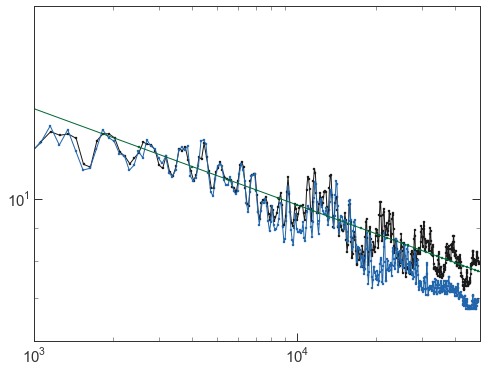

In [84]:
plt.figure(figsize=(8,6))
plt.semilogx(slow_t[t_ixes_slow], slow_D)
plt.semilogx(fast_t[t_ixes_fast], fast_D)

tt = np.linspace(1E3,1.5E5,100)
plt.loglog(tt, 39/tt**0.15)
plt.xlim(1E3, 5E4)
plt.ylim(6,20)

Try fitting a power law $f(t) = A t^{-\alpha}$.

In [87]:
import scipy.optimize as so

In [116]:
def model(p, t):
    A,a = p
    return A / t**a

In [125]:
def errfunc(p, t, y):
    return (y - model(p,t)) / 100.

def cost(p, t, y):
    return sum(errfunc(p, t, y))

In [135]:
res = so.leastsq(errfunc, x0=(40,0.15), args=(slow_t[t_ixes_slow][1:], slow_D[1:]), full_output=True)
p_opt = res[0]
print(res[3], res[4])
print(p_opt)

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 1
[ 28.20848004   0.1177944 ]


In [136]:
res = so.leastsq(errfunc, x0=(40,0.15), args=(fast_t[t_ixes_fast][1:], fast_D[1:]), full_output=True)
p_opt = res[0]
print(res[3], res[4])
print(p_opt)

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 1
[ 33.78663429   0.14296705]


(6, 20)

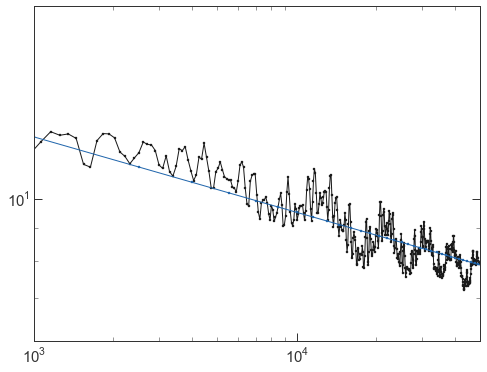

In [132]:
plt.figure(figsize=(8,6))
plt.semilogx(slow_t[t_ixes_slow], slow_D)

tt = np.linspace(1E3,1.5E5,100)
plt.loglog(tt, model(p_opt,tt))
plt.xlim(1E3, 5E4)
plt.ylim(6,20)

The other thing we could test is the KLD:
$$
    D_{\rm KL} = \int dx \, \rho(x) \, \ln \frac{\rho(x)}{\rho_{E_0}(x)} \approx \sum_i \ln \frac{\rho(x_i)}{\rho_{E_0}(x_i)}
$$
for samples of $\rho(x)$, right?

In [137]:
bw = 5.

In [140]:
from sklearn.neighbors import KernelDensity
from sklearn.grid_search import GridSearchCV

grid = GridSearchCV(KernelDensity(kernel='epanechnikov'),
                    {'bandwidth': np.logspace(-2, 2., 30)},
                    cv=10) # 20-fold cross-validation
grid.fit(slow_ball[-1,:,:3])
bw = grid.best_params_['bandwidth']
print(grid.best_params_)

{'bandwidth': 14.873521072935118}


In [ ]:
slow_D = []
t_ixes_slow = np.linspace(0, slow_ball.shape[0]-1, 128).astype(int)
for i in t_ixes_slow:
    # grid search every step
#     grid = GridSearchCV(KernelDensity(kernel='epanechnikov'),
#                         {'bandwidth': np.logspace(-2, 2., 30)},
#                         cv=20) # 20-fold cross-validation
#     grid.fit(slow_ball[-1,:,:3])
#     kde = KernelDensity(kernel='epanechnikov', bandwidth=grid.best_params_['bandwidth'])
    
    kde = KernelDensity(kernel='epanechnikov', bandwidth=bw)
    kde.fit(slow_ball[i,:,:3])
    kde_densy = np.exp(kde.score_samples(slow_ball[i,:,:3]))
    
    p_densy = predicted_density(slow_ball[i,:,:3])
    D = np.log(kde_densy / p_densy)
    slow_D.append(D[np.isfinite(D)].sum())

In [ ]:
fast_D = []
t_ixes_fast = np.linspace(0, fast_ball.shape[0]-1, 128).astype(int)
for i in t_ixes_fast:
    # grid search every step
#     grid = GridSearchCV(KernelDensity(kernel='epanechnikov'),
#                         {'bandwidth': np.logspace(-2, 2., 30)},
#                         cv=20) # 20-fold cross-validation
#     grid.fit(slow_ball[-1,:,:3])
#     kde = KernelDensity(kernel='epanechnikov', bandwidth=grid.best_params_['bandwidth'])

    kde = KernelDensity(kernel='epanechnikov', bandwidth=bw)
    kde.fit(fast_ball[i,:,:3])
    kde_densy = np.exp(kde.score_samples(fast_ball[i,:,:3]))
    
    p_densy = predicted_density(fast_ball[i,:,:3])
    D = np.log(kde_densy / p_densy)
    fast_D.append(D[np.isfinite(D)].sum())

In [ ]:
plt.figure(figsize=(8,6))
# plt.plot(slow_t[t_ixes_slow], np.array(slow_D) / 1000.)
# plt.plot(fast_t[t_ixes_fast], np.array(fast_D) / 1000.)
plt.semilogx(slow_t[t_ixes_slow], np.array(slow_D) / 1000.)
plt.semilogx(fast_t[t_ixes_fast], np.array(fast_D) / 1000.)
# plt.savefig("/Users/adrian/papers/papers/stream-morphology/figures/D_KL.pdf")

plt.xlim(5E3, 5E4)

### Do KNN density estimate, histogram density evaluated at points?

In [113]:
from sklearn.neighbors import KernelDensity

In [114]:
kde = KernelDensity()
kde.fit(rotated_slow)
slow_dens = kde.score_samples(rotated_slow)

In [115]:
kde = KernelDensity()
kde.fit(rotated_fast)
fast_dens = kde.score_samples(rotated_fast)

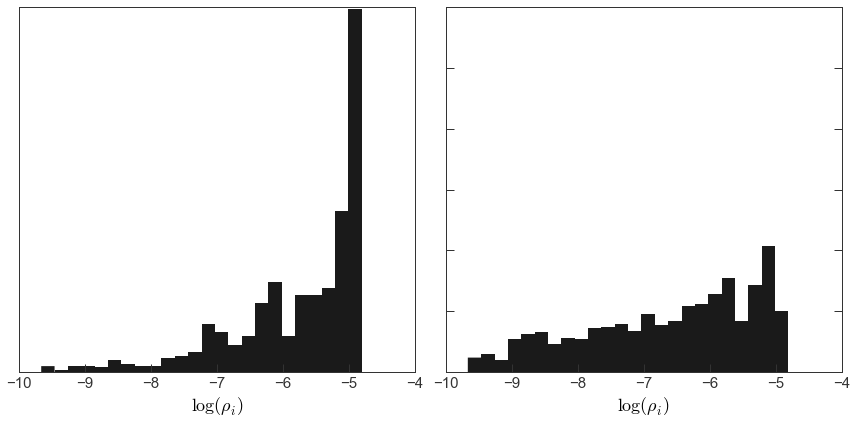

In [116]:
fig,axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(12,6))

# sd = np.exp(slow_dens)
# fd = np.exp(fast_dens)
sd = slow_dens
fd = fast_dens

bins = np.linspace(min(sd.min(), fd.min()),
                   max(sd.max(), fd.max()),
                   25)

n,bins,pa = axes[0].hist(sd, bins=bins)
n,bins,pa = axes[1].hist(fd, bins=bins)

axes[0].yaxis.set_visible(False)
axes[0].set_xlabel(r"$\log(\rho_i)$")
axes[1].set_xlabel(r"$\log(\rho_i)$")

fig.tight_layout()

Nice!! Ok maybe this will work as a metric...

In [119]:
from scipy.stats import entropy

In [120]:
H,ed = np.histogram(slow_dens, bins=35)
print(entropy(H))

H,ed = np.histogram(fast_dens, bins=35)
print(entropy(H))

2.29009601821
3.41076557196


### Now do this every few timesteps to plot mean density vs. time

In [121]:
bins = np.linspace(-15,-5.,50)

In [122]:
slow_t_ixes = np.logspace(0,np.log10(slow_ball.shape[0]-1), 128).astype(int)
mean_slow_dens = np.zeros_like(slow_t_ixes).astype(float)
slow_entropy = np.zeros_like(slow_t_ixes).astype(float)
for j,i in enumerate(slow_t_ixes):
    kde = KernelDensity(kernel='epanechnikov')
    kde.fit(slow_ball[i,:,:6])
    slow_dens = kde.score_samples(slow_ball[i,:,:6])
    mean_slow_dens[j] = np.mean(np.exp(slow_dens))
    slow_entropy[j] = entropy(np.histogram(slow_dens, bins=bins)[0])

/Users/adrian/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:2369: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / sum(pk, axis=0)


In [123]:
fast_t_ixes = np.logspace(0, np.log10(fast_ball.shape[0]-1), 128).astype(int)
mean_fast_dens = np.zeros_like(fast_t_ixes).astype(float)
fast_entropy = np.zeros_like(fast_t_ixes).astype(float)
for j,i in enumerate(fast_t_ixes):
    kde = KernelDensity(kernel='epanechnikov')
    kde.fit(fast_ball[i,:,:6])
    fast_dens = kde.score_samples(fast_ball[i,:,:6])
    mean_fast_dens[j] = np.mean(np.exp(fast_dens))
    fast_entropy[j] = entropy(np.histogram(fast_dens, bins=bins)[0])

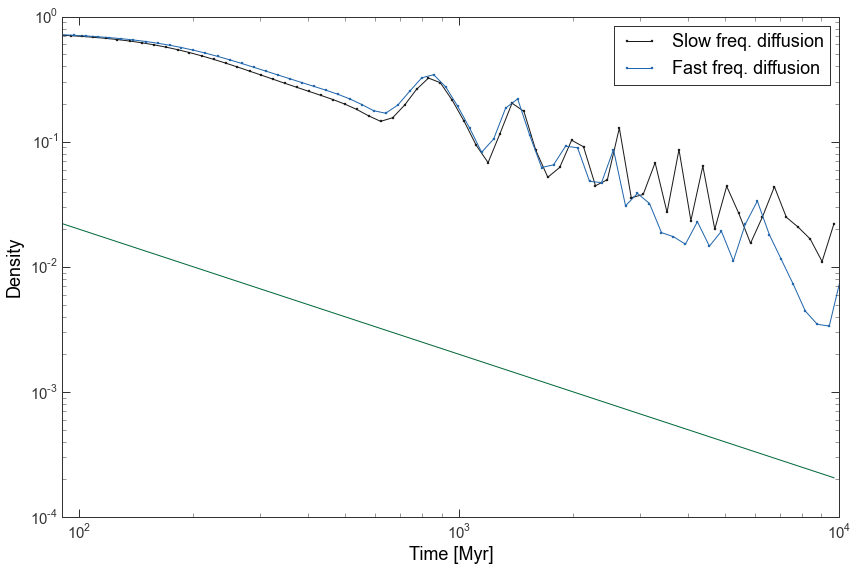

In [124]:
# fig,axes = plt.subplots(1,2,figsize=(8,6),sharex=True,sharey=True)
fig,axes = plt.subplots(1,1,figsize=(12,8))

axes.loglog(slow_t[slow_t_ixes], mean_slow_dens, label='Slow freq. diffusion')
axes.loglog(fast_t[fast_t_ixes], mean_fast_dens, label='Fast freq. diffusion')

derpt = np.logspace(np.log10(50),np.log10(slow_t.max()),100)
# for i in range(2):
#     axes[i].loglog(derpt, 2/derpt,marker=None)
axes.loglog(derpt, 2/derpt, marker=None)
axes.set_xlim(90,1E4)

axes.set_xlabel("Time [Myr]")
axes.set_ylabel("Density")

axes.legend(loc='upper right', fontsize=18)

fig.tight_layout()

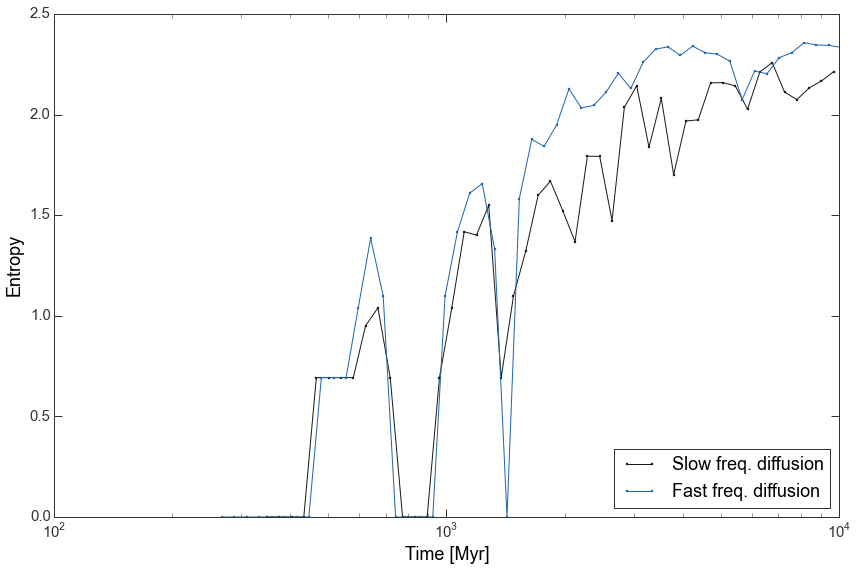

In [125]:
# fig,axes = plt.subplots(1,2,figsize=(8,6),sharex=True,sharey=True)
fig,axes = plt.subplots(1,1,figsize=(12,8))

axes.semilogx(slow_t[slow_t_ixes], slow_entropy, label='Slow freq. diffusion')
axes.semilogx(fast_t[fast_t_ixes], fast_entropy, label='Fast freq. diffusion')
# axes.plot(slow_t[slow_t_ixes], -slow_entropy, label='Slow freq. diffusion')
# axes.plot(fast_t[fast_t_ixes], -fast_entropy, label='Fast freq. diffusion')

derpt = np.logspace(np.log10(50),np.log10(slow_t.max()),100)
# axes.semilogx(derpt, 2-np.exp(-0.5*derpt/1000.), marker=None)

axes.set_xlabel("Time [Myr]")
axes.set_ylabel("Entropy")

axes.legend(loc='lower right', fontsize=18)

axes.set_xlim(100,1E4)

fig.tight_layout()

### Lyapunov time

In [74]:
def F_max(t,w):
    x,y,z,px,py,pz = w.T
    term1 = np.array([px, py, pz]).T
    term2 = potential.acceleration(w[...,:3])
    return np.hstack((term1,term2))

integrator = gi.DOPRI853Integrator(F_max)

In [75]:
slow_lyap = gd.lyapunov_max(slow_fast_w0[0], integrator, dt=2., nsteps=150000)
fast_lyap = gd.lyapunov_max(slow_fast_w0[1], integrator, dt=2., nsteps=150000)

3.55906637316e-05


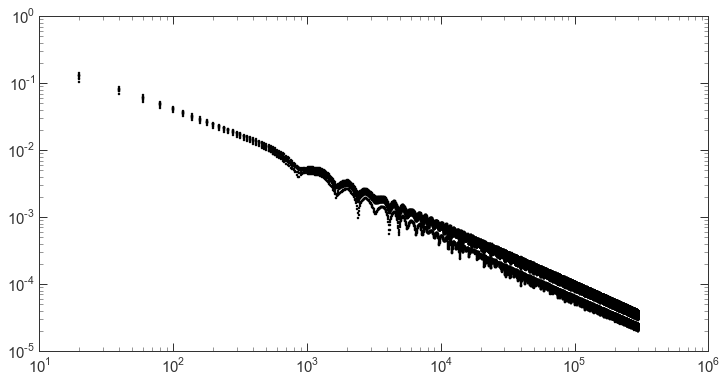

In [79]:
LEs,lyap_ts,lyap_ws = slow_lyap
print(LEs[-1].max())
plt.figure(figsize=(12,6))
plt.loglog(lyap_ts[::10][1:-1], LEs, linestyle='none', c='k');

5.21567856116e-05


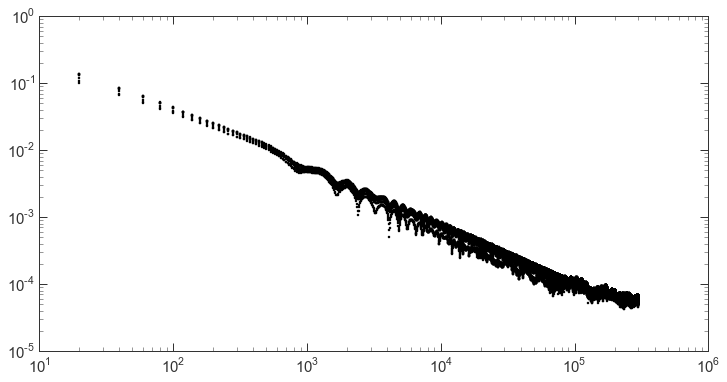

In [80]:
LEs,lyap_ts,lyap_ws = fast_lyap
print(LEs[-1].argmax())
plt.figure(figsize=(12,6))
plt.loglog(lyap_ts[::10][1:-1], LEs, linestyle='none', c='k');